In [ ]:
from probability import BayesNet, likelihood_weighting
import random

# Define a simple vocabulary
vocabulary = ['the', 'cat', 'sat', 'on', 'mat', 'dog', 'chased', 'mouse', 'ate', 'cheese']

# Create a Bayesian Network
bn = BayesNet()

# Add the first word node (W1)
w1_probs = {'the': 0.3, 'cat': 0.2, 'dog': 0.2, 'mouse': 0.1, 'cheese': 0.1}
w1_probs.update({w: 0.02 for w in vocabulary if w not in w1_probs})
bn.add(('W1', '', {(): w1_probs['the']}))

# Add nodes for the second word (W2), conditioned on the first word
for w1 in vocabulary:
    w2_probs = {
        'the': 0.1, 'cat': 0.2, 'dog': 0.2, 'sat': 0.2, 'chased': 0.2,
        'on': 0.05, 'mat': 0.05
    }
    w2_probs.update({w: 0.01 for w in vocabulary if w not in w2_probs})
    w2_cpt = {(True,): w2_probs[w1], (False,): 1 - w2_probs[w1]}
    bn.add((f'W2_{w1}', 'W1', w2_cpt))

# Add nodes for the third word (W3), conditioned on the previous two words
for w1 in vocabulary:
    for w2 in vocabulary:
        w3_probs = {
            'on': 0.3, 'the': 0.2, 'mat': 0.2, 'sat': 0.1, 'chased': 0.1,
            'ate': 0.1
        }
        w3_probs.update({w: 0.01 for w in vocabulary if w not in w3_probs})
        w3_cpt = {(True, True): w3_probs[w2], (True, False): 0, (False, True): 0, (False, False): 1 - w3_probs[w2]}
        bn.add((f'W3_{w1}_{w2}', f'W1 W2_{w1}', w3_cpt))

def approximate_distribution(X, e, bn, N=1000):
    return likelihood_weighting(X, e, bn, N)

def sample_from_distribution(distribution):
    words = list(distribution.keys())
    probabilities = list(distribution.values())
    return random.choices(words, weights=probabilities, k=1)[0]

def get_next_word(prev_words):
    if len(prev_words) == 0:
        distribution = approximate_distribution('W1', {}, bn)
        return sample_from_distribution({w: distribution[True] if w == 'the' else distribution[False] for w in vocabulary})
    elif len(prev_words) == 1:
        w1 = prev_words[0]
        distribution = approximate_distribution(f'W2_{w1}', {'W1': True}, bn)
        return sample_from_distribution({w: distribution[True] if w == w1 else distribution[False] for w in vocabulary})
    else:
        w1, w2 = prev_words[-2:]
        distribution = approximate_distribution(f'W3_{w1}_{w2}', {'W1': True, f'W2_{w1}': True}, bn)
        return sample_from_distribution({w: distribution[True] if w == w2 else distribution[False] for w in vocabulary})

# Generate a sentence
sentence = []
for _ in range(7):  # Generate a 7-word sentence
    next_word = get_next_word(sentence[-2:])  # Only pass the last two words
    sentence.append(next_word)
    print(f"Next word: {next_word}")

print(f"Generated sentence: {' '.join(sentence)}")


Next word: mat
Next word: cheese
Next word: on
Next word: cat
Next word: cheese
Next word: ate
Next word: dog
Generated sentence: mat cheese on cat cheese ate dog


In [ ]:
from probability import BayesNet, enumeration_ask

# Define a simple vocabulary
vocabulary = ['the', 'cat', 'sat', 'on', 'mat']

# Create a Bayesian Network
bn = BayesNet()

# Add the first word node (W1)
w1_prob = 1/len(vocabulary)
bn.add(('W1', '', {(): w1_prob}))

# Add nodes for the second word (W2), conditioned on the first word
for w1 in vocabulary:
    w2_cpt = {(w1_val,): 1/len(vocabulary) if w1_val else 0 for w1_val in [True, False]}
    bn.add((f'W2_{w1}', 'W1', w2_cpt))

# Function to get the most probable next word
def get_next_word(prev_word=None):
    if prev_word is None:
        # For the first word
        distribution = enumeration_ask('W1', {}, bn)
    else:
        # For the second word
        distribution = enumeration_ask(f'W2_{prev_word}', {'W1': True}, bn)
    return max(vocabulary, key=lambda w: distribution[True] if w == prev_word else distribution[False])

# Test the model
sentence = []

# Generate the first word
first_word = get_next_word()
sentence.append(first_word)
print(f"First word: {first_word}")

# Generate the second word
second_word = get_next_word(first_word)
sentence.append(second_word)
print(f"Second word: {second_word}")

print(f"Generated sentence: {' '.join(sentence)}")

In [ ]:
from probability import BayesNet, likelihood_weighting
import random

# Define word categories
determiners = ['the', 'a']
nouns = ['cat', 'dog', 'mouse', 'cheese', 'mat']
verbs = ['sat', 'chased', 'ate', 'jumped']
prepositions = ['on', 'under', 'near']

vocabulary = determiners + nouns + verbs + prepositions

# Create a Bayesian Network
bn = BayesNet()

# Add nodes (simplified for brevity)
bn.add(('W1', '', {(): 0.5}))  # 50% chance of starting with a determiner
for w1 in vocabulary:
    bn.add((f'W2_{w1}', 'W1', {(True,): 0.5, (False,): 0.5}))
    for w2 in vocabulary:
        bn.add((f'W3_{w1}_{w2}', f'W1 W2_{w1}', {(True, True): 0.5, (True, False): 0, (False, True): 0, (False, False): 0.5}))

def approximate_distribution(X, e, bn, N=1000):
    return likelihood_weighting(X, e, bn, N)

def sample_from_distribution(distribution):
    words = list(distribution.keys())
    probabilities = list(distribution.values())
    return random.choices(words, weights=probabilities, k=1)[0]

def get_word_category(word):
    if word in determiners:
        return 'DET'
    elif word in nouns:
        return 'NOUN'
    elif word in verbs:
        return 'VERB'
    elif word in prepositions:
        return 'PREP'

def get_next_word(prev_words, allowed_categories):
    if len(prev_words) == 0:
        distribution = approximate_distribution('W1', {}, bn)
        words = [w for w in vocabulary if get_word_category(w) in allowed_categories]
        return sample_from_distribution({w: distribution[True] if w in determiners else distribution[False] for w in words})
    elif len(prev_words) == 1:
        w1 = prev_words[0]
        distribution = approximate_distribution(f'W2_{w1}', {'W1': True}, bn)
        words = [w for w in vocabulary if get_word_category(w) in allowed_categories]
        return sample_from_distribution({w: distribution[True] if w == w1 else distribution[False] for w in words})
    else:
        w1, w2 = prev_words[-2:]
        distribution = approximate_distribution(f'W3_{w1}_{w2}', {'W1': True, f'W2_{w1}': True}, bn)
        words = [w for w in vocabulary if get_word_category(w) in allowed_categories]
        return sample_from_distribution({w: distribution[True] if w == w2 else distribution[False] for w in words})

def generate_sentence():
    sentence = []
    structure = ['DET', 'NOUN', 'VERB', 'PREP', 'DET', 'NOUN']
    for category in structure:
        word = get_next_word(sentence[-2:], [category])
        sentence.append(word)
    return sentence

# Generate multiple sentences
for _ in range(5):
    sentence = generate_sentence()
    print(f"Generated sentence: {' '.join(sentence)}")

Generated sentence: the mouse jumped near the cat
Generated sentence: the cheese sat on a dog
Generated sentence: the dog jumped near the dog
Generated sentence: a dog ate on the cheese
Generated sentence: a mouse sat on the dog


In [ ]:
from probability import BayesNet, likelihood_weighting
import random

# Define word categories
determiners = ['the', 'a']
nouns = ['cat', 'dog', 'mouse', 'cheese', 'mat']
verbs = ['sat', 'chased', 'ate']
prepositions = ['on', 'under', 'near']

vocabulary = determiners + nouns + verbs + prepositions

# Create a Bayesian Network
bn = BayesNet()

# Add nodes (simplified for brevity)
bn.add(('W1', '', {(): 0.5}))  # 50% chance of starting with a determiner
for w1 in vocabulary:
    bn.add((f'W2_{w1}', 'W1', {(True,): 0.5, (False,): 0.5}))
    for w2 in vocabulary:
        bn.add((f'W3_{w1}_{w2}', f'W1 W2_{w1}', {(True, True): 0.5, (True, False): 0, (False, True): 0, (False, False): 0.5}))

def approximate_distribution(X, e, bn, N=1000):
    return likelihood_weighting(X, e, bn, N)

def sample_from_distribution(distribution):
    words = list(distribution.keys())
    probabilities = list(distribution.values())
    return random.choices(words, weights=probabilities, k=1)[0]

def get_word_category(word):
    if word in determiners:
        return 'DET'
    elif word in nouns:
        return 'NOUN'
    elif word in verbs:
        return 'VERB'
    elif word in prepositions:
        return 'PREP'

def get_next_word(prev_words, allowed_categories=None):
    if allowed_categories is None:
        allowed_categories = ['DET', 'NOUN', 'VERB', 'PREP']

    if len(prev_words) == 0:
        distribution = approximate_distribution('W1', {}, bn)
        words = [w for w in vocabulary if get_word_category(w) in allowed_categories]
        return sample_from_distribution({w: distribution[True] if w in determiners else distribution[False] for w in words})
    elif len(prev_words) == 1:
        w1 = prev_words[0]
        distribution = approximate_distribution(f'W2_{w1}', {'W1': True}, bn)
    else:
        w1, w2 = prev_words[-2:]
        distribution = approximate_distribution(f'W3_{w1}_{w2}', {'W1': True, f'W2_{w1}': True}, bn)

    words = [w for w in vocabulary if get_word_category(w) in allowed_categories]
    return sample_from_distribution({w: distribution[True] if w == prev_words[-1] else distribution[False] for w in words})

def generate_sentence():
    sentence = []
    while len(sentence) < 10:  # Maximum sentence length
        if not sentence:
            allowed_categories = ['DET', 'NOUN']
        elif get_word_category(sentence[-1]) == 'DET':
            allowed_categories = ['NOUN']
        elif get_word_category(sentence[-1]) == 'NOUN':
            allowed_categories = ['VERB', 'PREP']
        elif get_word_category(sentence[-1]) == 'VERB':
            allowed_categories = ['DET', 'PREP', 'NOUN']
        elif get_word_category(sentence[-1]) == 'PREP':
            allowed_categories = ['DET', 'NOUN']

        word = get_next_word(sentence[-2:] if len(sentence) > 1 else sentence, allowed_categories)
        sentence.append(word)

        if len(sentence) >= 3 and get_word_category(sentence[-1]) in ['NOUN', 'VERB']:
            if random.random() < 0.3:  # 30% chance to end the sentence
                break

    return sentence

# Generate multiple sentences
for _ in range(5):
    sentence = generate_sentence()
    print(f"Generated sentence: {' '.join(sentence)}")

Generated sentence: mat chased cat
Generated sentence: dog sat dog ate
Generated sentence: the cheese near mouse sat mouse near cat under dog
Generated sentence: the dog near cat under mouse
Generated sentence: mouse on cheese


<ipython-input-22-3222861111f8>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


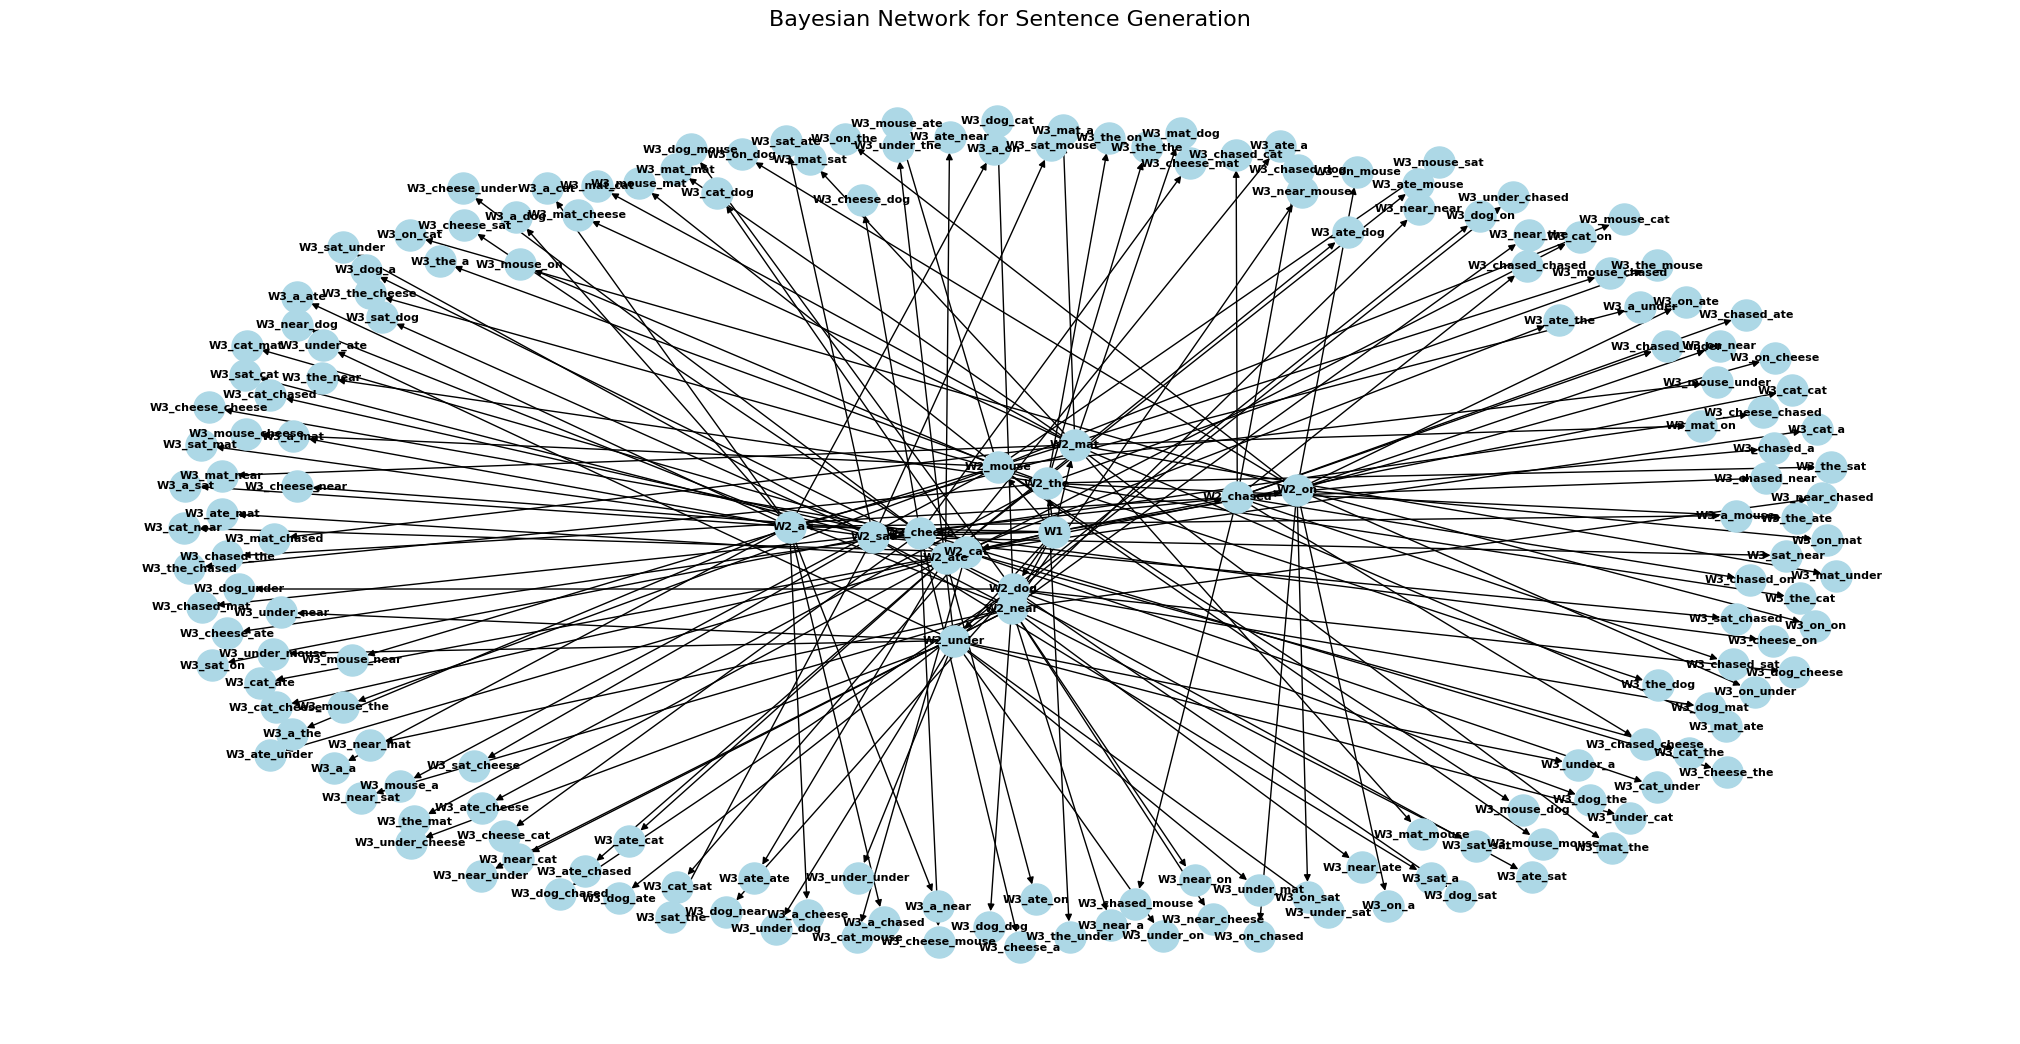

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define word categories
determiners = ['the', 'a']
nouns = ['cat', 'dog', 'mouse', 'cheese', 'mat']
verbs = ['sat', 'chased', 'ate']
prepositions = ['on', 'under', 'near']

vocabulary = determiners + nouns + verbs + prepositions

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node('W1')
for w1 in vocabulary:
    G.add_node(f'W2_{w1}')
    G.add_edge('W1', f'W2_{w1}')
    for w2 in vocabulary:
        G.add_node(f'W3_{w1}_{w2}')
        G.add_edge(f'W2_{w1}', f'W3_{w1}_{w2}')

# Set up the plot
plt.figure(figsize=(20, 10))

# Draw the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=500, font_size=8, font_weight='bold')

# Add edge labels
edge_labels = {(u, v): '' for (u, v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Bayesian Network for Sentence Generation", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
sentences = [
"The quick brown fox jumps over the lazy dog.",
"I love to eat pizza with extra cheese and mushrooms.",
"The sun is shining brightly in the clear blue sky.",
"My favorite hobby is reading science fiction novels.",
"She plays the piano beautifully every evening.",
"The old man walked slowly through the park.",
"Children are playing happily in the playground.",
"The cat curled up on the soft cushion and fell asleep.",
"He always drinks his coffee black with no sugar.",
"The train arrived at the station right on time.",
"The busy bees buzzed around the colorful flowers.",
"She baked a delicious chocolate cake for her friend's birthday.",
"The ocean waves crashed against the rocky shore.",
"He studied hard for his final exams all week long.",
"The chef prepared a gourmet meal with fresh ingredients.",
"The friendly dog wagged its tail and greeted everyone.",
"They went on a long hike through the dense forest.",
"The artist painted a beautiful landscape on the canvas.",
"The children built a snowman after the heavy snowfall.",
"She wrote a heartfelt letter to her grandmother.",
"The museum displayed ancient artifacts from various civilizations.",
"He fixed the leaky faucet with his trusty toolbox.",
"The football team celebrated their victory in the championship.",
"The librarian quietly shelved the returned books.",
"They watched a stunning sunset from the beach.",
"The detective solved the mysterious case after weeks of investigation.",
"She planted colorful flowers in her garden every spring.",
"The astronomer observed distant galaxies through his powerful telescope.",
"He learned to play the guitar by watching online tutorials.",
"The chef's signature dish won first prize in the cooking competition.",
"They explored the ancient ruins of a long-lost civilization.",
"The comedian's jokes had the audience laughing uncontrollably.",
"She adopted a rescue puppy from the local animal shelter.",
"The firefighters bravely battled the intense forest fire.",
"He composed a beautiful symphony inspired by nature.",
"The athlete trained rigorously for the upcoming marathon.",
"The magician amazed the crowd with his incredible illusions.",
"She volunteered at the homeless shelter every weekend.",
"The scientist conducted groundbreaking research in her laboratory.",
"They embarked on an adventurous road trip across the country.",
"The actor delivered a powerful performance in the Broadway play.",
"She designed an eco-friendly house using sustainable materials.",
"The pilot safely landed the plane during the turbulent storm.",
"He wrote a bestselling novel based on his childhood experiences.",
"The archaeologist uncovered ancient artifacts at the excavation site."
]

In [ ]:
import time
import math
import random
import numpy as np
from probability import BayesNet, likelihood_weighting
import torch
import torch.nn as nn

# Shared data and vocabulary
sentences = [
    "the cat sat on the mat",
    "a dog chased the mouse",
    "the cheese was eaten by the mouse",
    "a cat and a dog ran",
    "the mat was under the table"
]

vocab = list(set(' '.join(sentences).split()))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

# Bayesian Network Model
class BayesianLanguageModel:
    def __init__(self, sentences, vocab):
        self.bn = BayesNet()
        self.vocab = vocab
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i: w for w, i in self.word2idx.items()}

        # Initialize BayesNet (simplified for brevity)
        self.bn.add(('W1', '', {(): 0.5}))
        for w1 in vocab:
            self.bn.add((f'W2_{w1}', 'W1', {(True,): 0.5, (False,): 0.5}))
            for w2 in vocab:
                self.bn.add((f'W3_{w1}_{w2}', f'W1 W2_{w1}', {(True, True): 0.5, (True, False): 0, (False, True): 0, (False, False): 0.5}))

    def get_next_word_prob(self, context):
        if len(context) == 0:
            distribution = likelihood_weighting('W1', {}, self.bn, 1000)
            return {w: distribution[True] if i == 0 else distribution[False] for w, i in self.word2idx.items()}
        elif len(context) == 1:
            w1 = context[0]
            distribution = likelihood_weighting(f'W2_{w1}', {'W1': True}, self.bn, 1000)
            return {w: distribution[True] if w == w1 else distribution[False] for w in self.vocab}
        else:
            w1, w2 = context[-2:]
            distribution = likelihood_weighting(f'W3_{w1}_{w2}', {'W1': True, f'W2_{w1}': True}, self.bn, 1000)
            return {w: distribution[True] if w == w2 else distribution[False] for w in self.vocab}

    def evaluate(self, sentences):
        total_log_likelihood = 0
        total_words = 0
        start_time = time.time()

        for sentence in sentences:
            words = sentence.split()
            for i in range(1, len(words)):
                context = words[max(0, i-2):i]
                probs = self.get_next_word_prob(context)
                total_log_likelihood += math.log(probs[words[i]] + 1e-10)  # add smoothing
                total_words += 1

        perplexity = math.exp(-total_log_likelihood / total_words)
        evaluation_time = time.time() - start_time
        return perplexity, evaluation_time


    def generate_text(self, start_words, max_length=10):
        context = start_words.split()
        generated_text = context.copy()

        for _ in range(max_length - len(context)):
            probs = self.get_next_word_prob(context[-2:])
            next_word = max(probs, key=probs.get)
            generated_text.append(next_word)
            context = generated_text[-2:]

            if next_word == '<END>':
                break

        return ' '.join(generated_text)

# Self-Attention Model
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size=64, num_heads=4):
        super(SelfAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change to (seq_len, batch, features)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)  # Change back to (batch, seq_len, features)
        return self.fc(attn_output)

def train_self_attention(model, sentences, word2idx, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        total_loss = 0
        for sentence in sentences:
            words = ['<START>'] + sentence.split() + ['<END>']
            input_seq = torch.tensor([word2idx.get(w, word2idx['<UNK>']) for w in words[:-1]])
            target_seq = torch.tensor([word2idx.get(w, word2idx['<UNK>']) for w in words[1:]])

            output = model(input_seq.unsqueeze(0))
            loss = criterion(output.squeeze(0), target_seq)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}')

def evaluate_self_attention(model, sentences, word2idx):
    model.eval()
    total_log_likelihood = 0
    total_words = 0
    start_time = time.time()

    with torch.no_grad():
        for sentence in sentences:
            words = ['<START>'] + sentence.split() + ['<END>']
            input_seq = torch.tensor([word2idx.get(w, word2idx['<UNK>']) for w in words[:-1]])
            target_seq = torch.tensor([word2idx.get(w, word2idx['<UNK>']) for w in words[1:]])

            output = model(input_seq.unsqueeze(0))
            probs = torch.softmax(output.squeeze(0), dim=1)

            for i in range(len(target_seq)):
                total_log_likelihood += math.log(probs[i, target_seq[i]].item() + 1e-10)
                total_words += 1

    perplexity = math.exp(-total_log_likelihood / total_words)
    evaluation_time = time.time() - start_time
    return perplexity, evaluation_time


def generate_text_sa(model, start_words, word2idx, idx2word, max_length=10):
    model.eval()
    context = ['<START>'] + start_words.split()
    generated_text = context[1:]

    with torch.no_grad():
        for _ in range(max_length - len(context) + 1):
            input_seq = torch.tensor([word2idx.get(w, word2idx['<UNK>']) for w in context])
            output = model(input_seq.unsqueeze(0))
            probs = torch.softmax(output[0, -1], dim=0)
            next_word_idx = torch.multinomial(probs, 1).item()
            next_word = idx2word[next_word_idx]

            generated_text.append(next_word)
            context.append(next_word)

            if next_word == '<END>':
                break

    return ' '.join(generated_text)

# Main comparison
if __name__ == "__main__":
    # Prepare data
    word2idx['<UNK>'] = len(word2idx)
    word2idx['<START>'] = len(word2idx)
    word2idx['<END>'] = len(word2idx)
    idx2word = {i: w for w, i in word2idx.items()}
    vocab_size = len(word2idx)

    # Bayesian Network Model
    bn_model = BayesianLanguageModel(sentences, vocab)
    bn_perplexity, bn_time = bn_model.evaluate(sentences)

    # Self-Attention Model
    sa_model = SelfAttentionModel(vocab_size)
    train_self_attention(sa_model, sentences, word2idx)
    sa_perplexity, sa_time = evaluate_self_attention(sa_model, sentences, word2idx)

    # Print results
    print("\nResults:")
    print(f"Bayesian Network - Perplexity: {bn_perplexity:.4f}, Time: {bn_time:.4f} seconds")
    print(f"Self-Attention - Perplexity: {sa_perplexity:.4f}, Time: {sa_time:.4f} seconds")


    # Qualitative evaluation
    print("\nQualitative Evaluation:")

    # Test contexts
    test_contexts = [
        "the cat",
        "a dog",
        "the cheese",
    ]

    print("Bayesian Network Model:")
    for context in test_contexts:
        generated_text = bn_model.generate_text(context)
        print(f"Context: '{context}' -> Generated: '{generated_text}'")

    print("\nSelf-Attention Model:")
    for context in test_contexts:
        generated_text = generate_text_sa(sa_model, context, word2idx, idx2word)
        print(f"Context: '{context}' -> Generated: '{generated_text}'")

Epoch 10/100, Loss: 5.8813
Epoch 20/100, Loss: 1.0940
Epoch 30/100, Loss: 0.8277
Epoch 40/100, Loss: 0.7976
Epoch 50/100, Loss: 0.7863
Epoch 60/100, Loss: 0.7805
Epoch 70/100, Loss: 0.7772
Epoch 80/100, Loss: 0.7855
Epoch 90/100, Loss: 0.7744
Epoch 100/100, Loss: 0.7730

Results:
Bayesian Network - Perplexity: 1.9908, Time: 12.8538 seconds
Self-Attention - Perplexity: 1.1730, Time: 0.0027 seconds

Qualitative Evaluation:
Bayesian Network Model:
Context: 'the cat' -> Generated: 'the cat cat cat table table cat cat table table'
Context: 'a dog' -> Generated: 'a dog dog cat table cat cat cat cat table'
Context: 'the cheese' -> Generated: 'the cheese cheese cat cat cat table table table table'

Self-Attention Model:
Context: 'the cat' -> Generated: 'the cat on the the mat <END>'
Context: 'a dog' -> Generated: 'a dog ran <END>'
Context: 'the cheese' -> Generated: 'the cheese the mouse <END>'


In [ ]:
import time
import math
import random
import numpy as np
from probability import BayesNet, likelihood_weighting
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import psutil
import os

# Create vocabulary
def create_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence.split())
    vocab = list(vocab)
    vocab.extend(['<UNK>', '<START>', '<END>', '<PAD>'])
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}
    return vocab, word2idx, idx2word


vocab, word2idx, idx2word = create_vocab(sentences)

from probability import BayesNet
import math
import time

class BayesianLanguageModel:
    def __init__(self, vocab, sentences):
        self.bn = BayesNet()
        self.vocab = vocab
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i: w for w, i in self.word2idx.items()}

        # Initialize counts
        word_counts = {w: 1 for w in vocab}  # Add-1 smoothing
        bigram_counts = {(w1, w2): 1 for w1 in vocab for w2 in vocab}  # Add-1 smoothing
        trigram_counts = {(w1, w2, w3): 1 for w1 in vocab for w2 in vocab for w3 in vocab}  # Add-1 smoothing

        for sentence in sentences:
            words = ['<START>'] + sentence.split() + ['<END>']
            for i in range(len(words)):
                word_counts[words[i]] += 1
                if i > 0:
                    bigram_counts[(words[i-1], words[i])] += 1
                if i > 1:
                    trigram_counts[(words[i-2], words[i-1], words[i])] += 1

        # Create CPTs
        total_words = sum(word_counts.values())
        self.bn.add(('W1', '', {(): word_counts[vocab[0]] / total_words}))

        for w1 in vocab:
            total_bigrams = sum(bigram_counts[(w1, w2)] for w2 in vocab)
            cpt = {(True,): bigram_counts[(w1, vocab[0])] / total_bigrams,
                   (False,): 1 - (bigram_counts[(w1, vocab[0])] / total_bigrams)}
            self.bn.add((f'W2_{w1}', 'W1', cpt))

        for w1 in vocab:
            for w2 in vocab:
                total_trigrams = sum(trigram_counts[(w1, w2, w3)] for w3 in vocab)
                cpt = {(True, True): trigram_counts[(w1, w2, vocab[0])] / total_trigrams,
                       (True, False): 1 - (trigram_counts[(w1, w2, vocab[0])] / total_trigrams),
                       (False, True): trigram_counts[(w1, w2, vocab[0])] / total_trigrams,
                       (False, False): 1 - (trigram_counts[(w1, w2, vocab[0])] / total_trigrams)}
                self.bn.add((f'W3_{w1}_{w2}', f'W1 W2_{w1}', cpt))

        # Precompute node lookups
        self.w1_node = self.bn.variable_node('W1')
        self.w2_nodes = {w1: self.bn.variable_node(f'W2_{w1}') for w1 in vocab}
        self.w3_nodes = {(w1, w2): self.bn.variable_node(f'W3_{w1}_{w2}') for w1 in vocab for w2 in vocab}

    def get_next_word_prob(self, context):
        if len(context) == 0:
            prob_first = self.w1_node.p(True, {})
            return {w: prob_first if w == self.vocab[0] else (1 - prob_first) / (len(self.vocab) - 1) for w in self.vocab}
        elif len(context) == 1:
            w1 = context[0]
            node = self.w2_nodes[w1]
            prob_first = node.p(True, {'W1': True})
            return {w: prob_first if w == self.vocab[0] else (1 - prob_first) / (len(self.vocab) - 1) for w in self.vocab}
        else:
            w1, w2 = context[-2:]
            node = self.w3_nodes[(w1, w2)]
            prob_first = node.p(True, {'W1': True, f'W2_{w1}': True})
            return {w: prob_first if w == self.vocab[0] else (1 - prob_first) / (len(self.vocab) - 1) for w in self.vocab}

    def evaluate(self, sentences):
        total_log_likelihood = 0
        total_words = 0
        start_time = time.time()

        for sentence in sentences:
            words = ['<START>'] + sentence.split() + ['<END>']
            for i in range(1, len(words)):
                context = words[max(0, i-2):i]
                probs = self.get_next_word_prob(context)
                total_log_likelihood += math.log(probs.get(words[i], 1e-10))
                total_words += 1

        evaluation_time = time.time() - start_time

        if total_words == 0:
            return float('inf'), evaluation_time  # Return infinite perplexity if no words were evaluated

        perplexity = math.exp(-total_log_likelihood / total_words)
        return perplexity, evaluation_time


# Self-Attention Model
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, num_heads=8, num_layers=3):
        super(SelfAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return self.fc(x)

class LanguageModelDataset(Dataset):
    def __init__(self, sentences, word2idx, max_len=50):
        self.sentences = sentences
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = ['<START>'] + self.sentences[idx].split()[:self.max_len-2] + ['<END>']
        input_seq = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in words[:-1]]
        target_seq = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in words[1:]]

        # Pad sequences
        input_seq += [self.word2idx['<PAD>']] * (self.max_len - len(input_seq))
        target_seq += [self.word2idx['<PAD>']] * (self.max_len - len(target_seq))

        return torch.tensor(input_seq), torch.tensor(target_seq)

def train_self_attention(model, train_loader, val_loader, num_epochs=10, patience=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
    optimizer = torch.optim.Adam(model.parameters())

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for input_seq, target_seq in train_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)

            output = model(input_seq)
            loss = criterion(output.view(-1, len(word2idx)), target_seq.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for input_seq, target_seq in val_loader:
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                output = model(input_seq)
                val_loss += criterion(output.view(-1, len(word2idx)), target_seq.view(-1)).item()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

def evaluate_self_attention(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    total_log_likelihood = 0
    total_words = 0
    start_time = time.time()

    with torch.no_grad():
        for input_seq, target_seq in test_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            probs = torch.softmax(output, dim=2)

            for i in range(target_seq.size(0)):
                for j in range(target_seq.size(1)):
                    if target_seq[i, j] != word2idx['<PAD>']:
                        total_log_likelihood += math.log(probs[i, j, target_seq[i, j]].item() + 1e-10)
                        total_words += 1

    perplexity = math.exp(-total_log_likelihood / total_words)
    evaluation_time = time.time() - start_time
    return perplexity, evaluation_time

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # in MB

# Main comparison
if __name__ == "__main__":
    # Load data and create vocabulary
    # sentences = load_dataset('path_to_your_dataset.txt')  # Replace with your dataset path
    vocab, word2idx, idx2word = create_vocab(sentences)

    # Prepare data
    train_sentences, test_sentences = train_test_split(sentences, test_size=0.2, random_state=42)
    train_sentences, val_sentences = train_test_split(train_sentences, test_size=0.2, random_state=42)

    # Bayesian Network Model
    print("Evaluating Bayesian Network Model...")
    bn_model = BayesianLanguageModel(vocab, train_sentences)
    bn_memory_before = get_memory_usage()
    bn_perplexity, bn_time = bn_model.evaluate(test_sentences)
    bn_memory_after = get_memory_usage()

    # Self-Attention Model
    print("Training Self-Attention Model...")
    sa_model = SelfAttentionModel(len(word2idx))
    train_dataset = LanguageModelDataset(train_sentences, word2idx)
    val_dataset = LanguageModelDataset(val_sentences, word2idx)
    test_dataset = LanguageModelDataset(test_sentences, word2idx)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    sa_memory_before = get_memory_usage()
    train_self_attention(sa_model, train_loader, val_loader)
    sa_perplexity, sa_time = evaluate_self_attention(sa_model, test_loader)
    sa_memory_after = get_memory_usage()

    # Print results
    print("\nResults:")
    print(f"Bayesian Network - Perplexity: {bn_perplexity:.4f}, Time: {bn_time:.4f} seconds, Memory Usage: {bn_memory_after - bn_memory_before:.2f} MB")
    print(f"Self-Attention - Perplexity: {sa_perplexity:.4f}, Time: {sa_time:.4f} seconds, Memory Usage: {sa_memory_after - sa_memory_before:.2f} MB")

    # Test with limited data
    print("\nTesting with limited data (10% of original dataset)...")
    limited_train_sentences = train_sentences[:max(1, len(train_sentences)//10)]
    limited_val_sentences = val_sentences[:max(1, len(val_sentences)//10)]
    limited_test_sentences = test_sentences[:max(1, len(test_sentences)//10)]

    if len(limited_test_sentences) > 0:
        bn_model_limited = BayesianLanguageModel(vocab, train_sentences)
        bn_perplexity_limited, bn_time_limited = bn_model_limited.evaluate(limited_test_sentences)

        sa_model_limited = SelfAttentionModel(len(word2idx))
        limited_train_dataset = LanguageModelDataset(limited_train_sentences, word2idx)
        limited_val_dataset = LanguageModelDataset(limited_val_sentences, word2idx)
        limited_test_dataset = LanguageModelDataset(limited_test_sentences, word2idx)
        limited_train_loader = DataLoader(limited_train_dataset, batch_size=32, shuffle=True)
        limited_val_loader = DataLoader(limited_val_dataset, batch_size=32)
        limited_test_loader = DataLoader(limited_test_dataset, batch_size=32)

        train_self_attention(sa_model_limited, limited_train_loader, limited_val_loader)
        sa_perplexity_limited, sa_time_limited = evaluate_self_attention(sa_model_limited, limited_test_loader)

        print("Results with limited data:")
        print(f"Bayesian Network - Perplexity: {bn_perplexity_limited:.4f}, Time: {bn_time_limited:.4f} seconds")
        print(f"Self-Attention - Perplexity: {sa_perplexity_limited:.4f}, Time: {sa_time_limited:.4f} seconds")
    else:
        print("The limited dataset is empty. Skipping evaluation on limited data.")

Evaluating Bayesian Network Model...
Training Self-Attention Model...
Epoch 1/10, Train Loss: 3.2731, Val Loss: 3.3017
Epoch 2/10, Train Loss: 2.0899, Val Loss: 3.5692
Epoch 3/10, Train Loss: 1.6513, Val Loss: 3.6103
Epoch 4/10, Train Loss: 1.1892, Val Loss: 3.5412
Early stopping triggered after 4 epochs

Results:
Bayesian Network - Perplexity: 21.1335, Time: 0.0002 seconds, Memory Usage: 0.00 MB
Self-Attention - Perplexity: 20.5219, Time: 0.0334 seconds, Memory Usage: 0.00 MB

Testing with limited data (10% of original dataset)...
Epoch 1/10, Train Loss: 2.9262, Val Loss: 4.3518
Epoch 2/10, Train Loss: 1.3914, Val Loss: 4.3177
Epoch 3/10, Train Loss: 0.9429, Val Loss: 4.4233
Epoch 4/10, Train Loss: 0.5520, Val Loss: 4.5050
Epoch 5/10, Train Loss: 0.3562, Val Loss: 4.5577
Early stopping triggered after 5 epochs
Results with limited data:
Bayesian Network - Perplexity: 21.1335, Time: 0.0002 seconds
Self-Attention - Perplexity: 18.7001, Time: 0.0207 seconds


In [ ]:
import time
import math
from probability import BayesNet


# Usage in main script
bn_model = BayesianLanguageModel(vocab, train_sentences)

print("\nEvaluating Bayesian Network Model on full dataset...")
bn_perplexity, bn_time = bn_model.evaluate(test_sentences)

print(f"\nBayesian Network - Full Dataset Perplexity: {bn_perplexity:.4f}, Time: {bn_time:.4f} seconds")

# Limited dataset evaluation
limited_train_sentences = train_sentences[:max(1, len(train_sentences)//10)]
limited_test_sentences = test_sentences[:max(1, len(test_sentences)//10)]

bn_model_limited = BayesianLanguageModel(vocab, limited_train_sentences)

print("\nEvaluating Bayesian Network Model on limited dataset...")
bn_perplexity_limited, bn_time_limited = bn_model_limited.evaluate(limited_test_sentences)

print(f"\nBayesian Network - Limited Dataset Perplexity: {bn_perplexity_limited:.4f}, Time: {bn_time_limited:.4f} seconds")


Evaluating Bayesian Network Model on full dataset...

Bayesian Network - Full Dataset Perplexity: 21.1335, Time: 0.0002 seconds

Evaluating Bayesian Network Model on limited dataset...

Bayesian Network - Limited Dataset Perplexity: 21.1474, Time: 0.0002 seconds
